<a href="https://colab.research.google.com/github/LeticiaVieirg/crack_thermal_detection/blob/main/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Importação das bibliotecas

In [32]:
import os
import random
import warnings
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras import models, layers, Sequential
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.models import Sequential, Model, load_model
from keras.saving import register_keras_serializable
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import (Input, Reshape, Dropout, Dense, Flatten, BatchNormalization,
                                    Activation, LeakyReLU, ReLU, PReLU, Conv2D, Conv2DTranspose, RandomRotation)
warnings.filterwarnings('ignore')

In [33]:
# Parameters
IMG_SIZE = 256  # Original image size: [200, 200, 3]
N_CHANNELS = 3
GEN_INPUT_SIZE = 100   # size of a vector given as input to the generator
BATCH_SIZE = 32

2. Carregando o dataset

In [34]:
# Conectar ao Google Drive para carregar o dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
# To combine images from training and validation directory
train_dir = '/content/drive/Shareddrives/Letícia Vieira Gonçalves - Pesquisa/Metal_Dataset/NEU Metal Surface Defects Data/train'
val_dir = '/content/drive/Shareddrives/Letícia Vieira Gonçalves - Pesquisa/Metal_Dataset/NEU Metal Surface Defects Data/valid'
test_dir = '/content/drive/Shareddrives/Letícia Vieira Gonçalves - Pesquisa/Metal_Dataset/NEU Metal Surface Defects Data/test'

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode=None,   # yields only image tensor (batch_size, image_size[0], image_size[1], num_channels), not tuple (image, label)
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    # shuffle=False
    )

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    label_mode=None,
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    # shuffle=False
    )

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode=None,
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    # shuffle=False
    )

# Combine both dataset to increase no. of samples
dataset = train_ds.concatenate(val_ds).concatenate(test_ds)

dataset = dataset.map(lambda x: (x / 127.5) - 1) # Normalize to ([-1, 1]), as common in GAN
len(dataset)

Found 1656 files.
Found 72 files.
Found 72 files.


58

Data augmentation - To generate more data for training

In [36]:
augment_layers = tf.keras.Sequential([
        RandomRotation(factor = (-0.05, 0.05)),  # random from (-18, 18) degrees : 0.05*360 = 18
      ])

aug_dataset1 = dataset.map(lambda image: augment_layers(image, training=True))
aug_dataset2 = dataset.map(lambda image: tf.image.flip_left_right(image))
aug_dataset3 = dataset.map(lambda image: tf.image.flip_up_down(image))
aug_dataset4 = dataset.map(lambda image: tf.image.rot90(image))

# Concatenate all augmented datasets
dataset = dataset.concatenate(aug_dataset1).concatenate(aug_dataset2).concatenate(aug_dataset3).concatenate(aug_dataset4)
len(dataset)

290

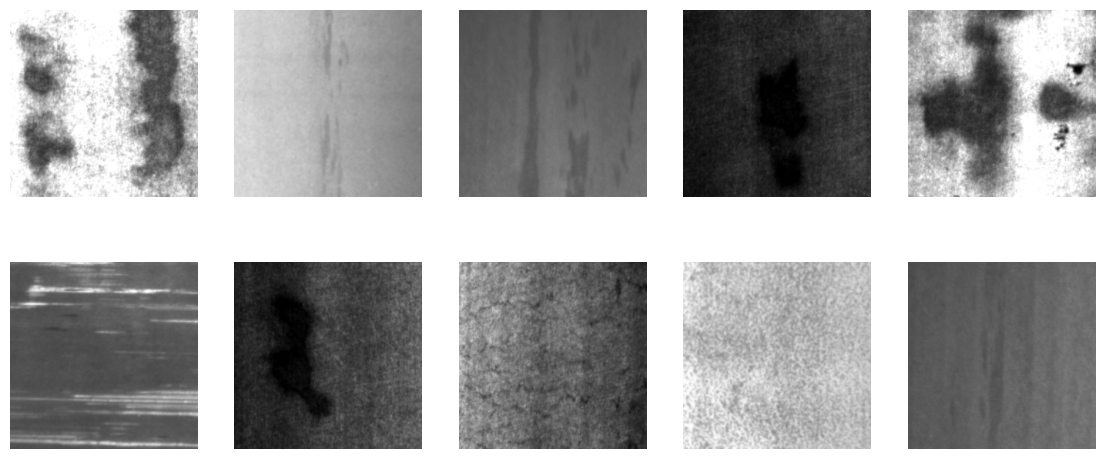

In [37]:
for images in dataset.skip(10):
  plt.figure(figsize=(14, 6))
  for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow((images[i].numpy() + 1) / 2.0)  # rescale [-1, 1] --> [0, 1] for imshow()
    plt.axis("off")
  break

Build the Generator

In [7]:
#Normalização
dataset = dataset.astype('float32')
dataset /= 255

In [38]:
def build_generator(input_size):
    """
    Constructs the generator network for the GAN.

    Parameters:
        input_size: The dimension of the input random vector for the generator.

    Returns:
        generator_model: A Keras model representing the generator architecture.
    """
    initializer = RandomNormal(mean=0.0, stddev=0.02)  # Set the kernel initializer

    generator_model = Sequential([

    # Block 1: Initial dense layer expanding the seed vector into a higher-dimensional space
    Dense(8 * 8 * 512, kernel_initializer=initializer, input_dim=input_size),  # Create initial feature set
    BatchNormalization(),  # for training stability
    ReLU(),
    Reshape((8, 8, 512)),

    # Block 2: Upscale to (8, 8, 512)
    Conv2DTranspose(256, kernel_size=5, strides=2, padding='same', use_bias=False, kernel_initializer=initializer),
    BatchNormalization(),
    ReLU(),

    # Block 3: Upscale to (16, 16, 256)
    Conv2DTranspose(128, kernel_size=5, strides=2, padding='same', use_bias=False, kernel_initializer=initializer),
    BatchNormalization(),
    ReLU(),

    # Block 4: Upscale to (32, 32, 128)
    Conv2DTranspose(64, kernel_size=3, strides=2, padding='same', use_bias=False, kernel_initializer=initializer),
    BatchNormalization(),
    ReLU(),

    Conv2DTranspose(32, kernel_size=3, strides=2, padding='same', use_bias=False, kernel_initializer=initializer),
    BatchNormalization(),
    ReLU(),

    # Block 5: Upscale to (64, 64, 3)
    Conv2DTranspose(3, kernel_size=3, strides=2, padding='same', use_bias=False, kernel_initializer=initializer),
    Activation('tanh'),  # to scale output pixel values between [-1, 1]
    ])

    return generator_model


generator_model = build_generator(GEN_INPUT_SIZE)
generator_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                      │ (None, 32768)               │       3,309,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32768)               │         131,072 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 16, 16, 256)         │       3,276,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 32, 32, 128)         │         819,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 64, 64, 64)          │          73,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_3 (ReLU)                       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 128, 128, 32)        │          18,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_4 (ReLU)                       │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 256, 256, 3)         │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 256, 256, 3)         │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,631,584 (29.11 MB)

 Trainable params: 7,565,088 (28.86 MB)

 Non-trainable params: 66,496 (259.75 KB)

Build Discriminator

In [39]:
def build_discriminator(img_size, num_channels):
    """
    Constructs the discriminator model for a GAN.

    Parameters:
        img_size: Length of one side of the square input image.
        num_channels: The number of channels in the input image.

    Returns:
        model: A Keras model instance representing the discriminator.
    """
    initializer = RandomNormal(mean=0.0, stddev=0.02)  # Initialize the weights of the layers

    model = Sequential([

            Conv2D(64, kernel_size=3, strides=2, padding='same', use_bias=False, input_shape=(img_size, img_size, num_channels),
                                                                                 kernel_initializer=initializer),
            LeakyReLU(alpha=0.2),

            Conv2D(128, kernel_size=3, strides=2, padding='same', use_bias=False, kernel_initializer=initializer),
            BatchNormalization(),  # Batch normalization for stabilizing training
            LeakyReLU(alpha=0.2),

            Conv2D(128, kernel_size=5, strides=2, padding='same', use_bias=False, kernel_initializer=initializer),
            BatchNormalization(),
            LeakyReLU(alpha=0.2),

            Conv2D(256, kernel_size=5, strides=2, padding='same', use_bias=False, kernel_initializer=initializer),
            BatchNormalization(),
            LeakyReLU(alpha=0.2),

            Conv2D(256, kernel_size=5, strides=2, padding='same', use_bias=False, kernel_initializer=initializer),
            BatchNormalization(),
            LeakyReLU(alpha=0.2),

            Conv2D(256, kernel_size=5, strides=2, padding='same', use_bias=False, kernel_initializer=initializer),
            BatchNormalization(),
            LeakyReLU(alpha=0.2),

            Conv2D(1, kernel_size=4, strides=1, padding='valid', use_bias=False, kernel_initializer=initializer),
            Flatten(),
            Activation('sigmoid'),  # Sigmoid -> to produce a probability value
            ])

    return model


discriminator = build_discriminator(IMG_SIZE, N_CHANNELS)
discriminator.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 128, 128, 64)        │           1,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 128)         │          73,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 128)         │         409,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 16, 16, 256)         │         819,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 8, 8, 256)           │       1,638,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 4, 4, 256)           │       1,638,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 4, 4, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 1, 1, 1)             │           4,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1)                   │              

 Total params: 4,589,248 (17.51 MB)

 Trainable params: 4,587,200 (17.50 MB)

 Non-trainable params: 2,048 (8.00 KB)

DCGAN Model Class

In [40]:
class DCGANModel(tf.keras.Model):
    """
    A custom subclass of keras.
    Model that implements a unique training routine and calculates loss metrics.
    """

    def __init__(self, random_vector_size, img_dimension, img_channels, **kwargs):
        """
        Args:
            random_vector_size: Dimension of the noise vector used by the generator.
            img_dimension: Length of each side of the square input image.
            img_channels: The number of color channels in the image.
        """
        super(DCGANModel, self).__init__(**kwargs)

        self.generator = build_generator(random_vector_size)
        self.discriminator = build_discriminator(img_dimension, img_channels)
        self.random_vector_size = random_vector_size


    def compute_generator_loss(self, discriminator_output):
        """
        Args:
            discriminator_output: Predictions from the discriminator for generated images.

        Returns:
            The computed loss value based on the discriminator's evaluation.
        """
        return cross_entropy_loss(tf.ones_like(discriminator_output), discriminator_output)


    def compute_discriminator_loss(self, real_predictions, fake_predictions, label_smoothing=0.1):
        """
        Args:
            real_predictions: Discriminator's output for real images.
            fake_predictions: Discriminator's output for images generated by the generator.

        Returns:
            The total loss computed for the discriminator.
        """
        real_loss_value = cross_entropy_loss(tf.ones_like(real_predictions) * (1 - label_smoothing), real_predictions)
        fake_loss_value = cross_entropy_loss(tf.zeros_like(fake_predictions), fake_predictions)
        return real_loss_value + fake_loss_value


    def compile_model(self, generator_optimizer, discriminator_optimizer):
        """
        Prepares the model for training by defining the optimizers.

        Args:
            generator_optimizer: Optimizer configured for the generator.
            discriminator_optimizer: Optimizer configured for the discriminator.
        """
        super(DCGANModel, self).compile()
        self.gen_optimizer = generator_optimizer   # to be used in next method
        self.disc_optimizer = discriminator_optimizer

    """
    The @tf.function decorator is used to optimize Python functions
    by converting them into TensorFlow computation graphs.
    """
    @tf.function
    def train_step(self, input_data):
        """
        Executes one training step using a given batch of data.

        Args:
            input_data: A batch sampled from the training dataset.

        Returns:
            A dictionary containing the losses for both generator and discriminator.
        """
        batch_size = tf.shape(input_data)[0]

        random_seed = tf.random.normal(shape=(batch_size, self.random_vector_size))

        with tf.GradientTape() as generator_tape, tf.GradientTape() as discriminator_tape:
            generated_image = self.generator(random_seed, training=True)

            real_predictions = self.discriminator(input_data, training=True)
            fake_predictions = self.discriminator(generated_image, training=True)

            generator_loss_value = self.compute_generator_loss(fake_predictions)   # generator takes only fake predictions
            discriminator_loss_value = self.compute_discriminator_loss(real_predictions, fake_predictions)

            generator_gradients = generator_tape.gradient(generator_loss_value, self.generator.trainable_variables)
            discriminator_gradients = discriminator_tape.gradient(discriminator_loss_value, self.discriminator.trainable_variables)

            self.gen_optimizer.apply_gradients(zip(generator_gradients, self.generator.trainable_variables))
            self.disc_optimizer.apply_gradients(zip(discriminator_gradients, self.discriminator.trainable_variables))

        return {
            "gen_loss": generator_loss_value,
            "disc_loss": discriminator_loss_value
        }

In [41]:
cross_entropy_loss = BinaryCrossentropy()
generator_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)    # as given in paper
discriminator_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)

# Instantiate and compile the model
dcgan = DCGANModel(GEN_INPUT_SIZE, IMG_SIZE, N_CHANNELS)
dcgan.compile_model(generator_optimizer, discriminator_optimizer)

Callbacks

In [42]:
# save images after every epoch
class SaveImages(tf.keras.callbacks.Callback):
    def __init__(self, generator, noise, num_rows, num_cols, margin):
        super(SaveImages, self).__init__()  # Properly call the parent constructor
        self.generator = generator
        self.noise = noise
        self.num_rows = num_rows
        self.num_cols = num_cols
        self.margin = margin

    def on_epoch_end(self, epoch, logs=None):
        # Generate images at the end of each epoch
        generated_images = self.generator(self.noise, training=False)
        generated_images = (generated_images + 1) / 2.0  # Rescaled from the [-1, 1] (common in GANs) to [0, 1] for visualization.

        # Plot images in a grid
        fig, ax = plt.subplots(self.num_rows, self.num_cols, figsize=(self.num_cols * 2, self.num_rows * 2))
        # fig.patch.set_facecolor('#fefefe')  # Set figure background color

        os.makedirs("/kaggle/working/Images", exist_ok=True)
        for i in range(self.num_rows):
            for j in range(self.num_cols):
                ax[i, j].imshow(generated_images[i * self.num_cols + j])
                ax[i, j].axis('off')  # Hide axes

                # Add a border around each image
                for spine in ax[i, j].spines.values():
                    spine.set_visible(True)
                    spine.set_linewidth(2)
                    spine.set_color('#b56576' if (i + j) % 2 == 0 else '#e56b6f')  # Alternate border colors
        plt.subplots_adjust(wspace=self.margin, hspace=self.margin)
        plt.savefig(f"/kaggle/working/Images/generated_image_epoch_{epoch + 1}.png", bbox_inches='tight', dpi=300)
        plt.close()

In [43]:
# Define constants for grid layout
NUM_ROWS = 3
NUM_COLS = 3
MARGIN = 0.3  # spacing between images in the grid

# Fixed seed for consistent image generation across epochs
fixed_seed = tf.random.normal(shape=(NUM_ROWS * NUM_COLS, GEN_INPUT_SIZE))

# Use SaveImages callback
save_images_callback = SaveImages(dcgan.generator, fixed_seed, NUM_ROWS, NUM_COLS, MARGIN)

In [ ]:
# Training the DCGAN model

EPOCHS = 100
with tf.device('/GPU:0'):
    history = dcgan.fit(dataset, epochs=EPOCHS, batch_size=BATCH_SIZE,
                        callbacks=[save_images_callback]
                       )

Epoch 1/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 762s 3s/step - disc_loss: 0.6344 - gen_loss: 4.3590
Epoch 2/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 72s 248ms/step - disc_loss: 0.7961 - gen_loss: 2.7625
Epoch 3/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 73s 251ms/step - disc_loss: 0.7407 - gen_loss: 2.9148
Epoch 4/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 73s 252ms/step - disc_loss: 0.6468 - gen_loss: 3.3825
Epoch 5/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 83s 257ms/step - disc_loss: 0.5593 - gen_loss: 3.9335
Epoch 6/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 74s 255ms/step - disc_loss: 0.5865 - gen_loss: 3.7972
Epoch 7/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 74s 256ms/step - disc_loss: 0.7380 - gen_loss: 2.7052
Epoch 8/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 74s 256ms/step - disc_loss: 0.9080 - gen_loss: 2.2180
Epoch 9/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 75s 259ms/step - disc_loss: 0.9123 - gen_loss: 2.1328
Epoch 10/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 74s 255ms/step - disc_loss: 0.8871 - gen_loss: 2.0352
Epoch 11/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 74s 254ms

In [ ]:
def plot_losses(history):
    generator_losses = history.history['gen_loss']
    discriminator_losses = history.history['disc_loss']
    plt.figure(figsize=(10, 5))
    plt.plot(generator_losses, label='Generator Loss')
    plt.plot(discriminator_losses, label='Discriminator Loss')
    # Adding aesthetics
    plt.title('Generator and Discriminator Losses')
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()  # Adjust layout to prevent clipping
    plt.show()

plot_losses(history)

Model Evaluation

In [ ]:
def generate_images(generator):
    n_images = 16  # generate 16 images
    noise = tf.random.normal([n_images, GEN_INPUT_SIZE])
    generated_images = generator(noise)
    plt.figure(figsize=(12, 12))
    for i in range(generated_images.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((generated_images[i, ...] +1) / 2.0)  # Rescale from [-1, 1] to [0, 1] for plt.imshow()
        plt.axis("off")
    plt.suptitle('Generated Surface Defects Images', color='blue', fontsize=16, fontfamily='fantasy')
    plt.show()

generate_images(dcgan.generator)